In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from numpy import unique, where
import matplotlib.pyplot as plt

import os
os.chdir('../../')

from modules import preproc
from modules.join_data import join_y
from modules import feature_eng
from modules import cluster_intelligence
from modules.evaluate_model import get_eval_scores
from modules.dbscan_grid_search import run_dbscan_gs, get_best_models
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows',150)
pd.set_option('display.max_columns',1000)

## Reading in data and preproc

In [2]:
# laptops
laptops = pd.read_json('full_data/laptops.json')
laptops = join_y(laptops, 'raw_data/laptops_sales.csv')
laptops = preproc.clean_cols(laptops)
laptops = preproc.fill_empty_lists(laptops)
laptops = preproc.preprocess_reviews(laptops)
laptops = feature_eng.generate_features(laptops)
#laptops = feature_eng.do_PCA(laptops)
laptops['TOTAL_SALES_QBINNED'] = pd.qcut(laptops['TOTAL_SALES'], 3, labels=[0,1,2])

# phones
phones = pd.read_json('full_data/smartphones.json')
phones = join_y(phones, 'raw_data/phone_sales.csv')
phones = preproc.clean_cols(phones)
phones = preproc.fill_empty_lists(phones)
phones = preproc.preprocess_reviews(phones)
phones = feature_eng.generate_features(phones)
#phones = feature_eng.do_PCA(phones)
phones['TOTAL_SALES_QBINNED'] = pd.qcut(phones['TOTAL_SALES'], 3, labels=[0,1,2])
# desktops
desktops = pd.read_json('full_data/desktops.json')
desktops = join_y(desktops, 'raw_data/desktops_sales.csv')
desktops = preproc.clean_cols(desktops)
desktops = preproc.fill_empty_lists(desktops)
desktops = preproc.preprocess_reviews(desktops)
desktops = feature_eng.generate_features(desktops)
#desktops = feature_eng.do_PCA(desktops)
desktops['TOTAL_SALES_QBINNED'] = pd.qcut(desktops['TOTAL_SALES'], 3, labels=[0,1,2])
# tablets
tablets = pd.read_json('full_data/tablets.json')
tablets = join_y(tablets, 'raw_data/tablet_sales.csv')
tablets = tablets[tablets['no_reviews'].notna()]
tablets = preproc.clean_cols(tablets)
tablets = preproc.fill_empty_lists(tablets)
tablets = preproc.preprocess_reviews(tablets)
tablets = feature_eng.generate_features(tablets)
#tablets = feature_eng.do_PCA(tablets)
tablets['TOTAL_SALES_QBINNED'] = pd.qcut(tablets['TOTAL_SALES'], 3, labels=[0,1,2])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]    

## Scaling

In [3]:
laptops = laptops.select_dtypes(include=['float', 'int64','int32','float64'])
laptops['price/Rvol'] = laptops['price/Rvol'].replace(np.inf, laptops['price/Rvol'].median())
for col in laptops.columns:
    laptops[col] = laptops[col].replace(np.nan, laptops[col].median())
laptops = (laptops-laptops.mean())/laptops.std()

laptops = feature_eng.get_y_true(laptops)



In [4]:
phones = phones.select_dtypes(include=['float', 'int64','int32','float64'])
phones['price/Rvol'] = phones['price/Rvol'].replace(np.inf, phones['price/Rvol'].median())
for col in phones.columns:
    phones[col] = phones[col].replace(np.nan, phones[col].median())
phones = (phones-phones.mean())/phones.std()

phones = feature_eng.get_y_true(phones)


In [5]:
tablets = tablets.select_dtypes(include=['float', 'int64','int32','float64'])
tablets['price/Rvol'] = tablets['price/Rvol'].replace(np.inf, tablets['price/Rvol'].median())
for col in tablets.columns:
    tablets[col] = tablets[col].replace(np.nan, tablets[col].median())
tablets = (tablets-tablets.mean())/tablets.std()

tablets = feature_eng.get_y_true(tablets)


In [6]:
desktops = desktops.select_dtypes(include=['float', 'int64','int32','float64'])
desktops['price/Rvol'] = desktops['price/Rvol'].replace(np.inf, desktops['price/Rvol'].median())
for col in desktops.columns:
    desktops[col] = desktops[col].replace(np.nan, desktops[col].median())
desktops = (desktops-desktops.mean())/desktops.std()

desktops = feature_eng.get_y_true(desktops)


In [7]:
laptops.name = 'laptops'
desktops.name = 'desktops'
phones.name = 'phones'
tablets.name = 'tablets'

## 'no_reviews','Rvol/%rec','pos_reviews'

In [17]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['no_reviews','Rvol/%rec','pos_reviews'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,f1_score
0,0.599567,0.680619,1.20,5,0.637527
0,0.587907,0.680619,1.05,7,0.630875
0,0.586310,0.680619,1.15,6,0.629954
0,0.586310,0.680619,1.20,3,0.629954
0,0.586310,0.680619,1.15,3,0.629954
0,0.586310,0.680619,1.20,4,0.629954
0,0.586310,0.680619,1.10,4,0.629954
0,0.586310,0.680619,1.25,2,0.629954
0,0.586310,0.680619,1.10,6,0.629954
0,0.586310,0.680619,1.10,2,0.629954


## no_reviews , Rvol/%rec

In [18]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['no_reviews','Rvol/%rec'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,f1_score
0,0.599567,0.680619,0.95,5,0.637527
0,0.690476,0.581187,1.10,4,0.631135
0,0.587907,0.680619,0.85,7,0.630875
0,0.586310,0.680619,1.00,2,0.629954
0,0.586310,0.680619,1.00,3,0.629954
0,0.586310,0.680619,1.10,2,0.629954
0,0.586310,0.680619,0.95,4,0.629954
0,0.586310,0.680619,1.05,2,0.629954
0,0.586310,0.680619,0.95,3,0.629954
0,0.586310,0.680619,1.00,4,0.629954


In [19]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['no_reviews'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,f1_score
0,0.711310,0.630619,0.60,6,0.668538
0,0.711310,0.630619,0.60,7,0.668538
0,0.624567,0.680619,0.65,5,0.651389
0,0.611310,0.680619,0.60,4,0.644105
0,0.611310,0.680619,0.60,5,0.644105
0,0.815476,0.516982,0.65,6,0.632795
0,0.586310,0.680619,0.60,3,0.629954
0,0.586310,0.680619,0.65,3,0.629954
0,0.586310,0.680619,0.70,2,0.629954
0,0.581944,0.680619,0.55,6,0.627426


In [20]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['Rvol/%rec'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,f1_score
0,0.701389,0.581187,0.80,3,0.635655
0,0.593202,0.680619,0.75,3,0.633911
0,0.593202,0.680619,0.75,4,0.633911
0,0.593202,0.680619,0.75,2,0.633911
0,0.591346,0.680619,0.65,7,0.632850
0,0.583333,0.680619,0.70,3,0.628232
0,0.583333,0.680619,0.70,2,0.628232
0,0.583333,0.680619,0.70,4,0.628232
0,0.579344,0.680619,0.65,6,0.625911
0,0.579344,0.680619,0.65,2,0.625911


In [21]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['no_reviews','Rvol/%rec','pos_reviews','neg_reviews'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,f1_score
0,0.587907,0.680619,1.65,2,0.630875
0,0.580616,0.680619,1.60,2,0.626653
0,0.579344,0.680619,1.40,3,0.625911
0,0.579344,0.680619,1.45,3,0.625911
0,0.579344,0.680619,1.35,3,0.625911
0,0.579344,0.680619,1.50,3,0.625911
0,0.579344,0.680619,1.55,2,0.625911
0,0.579344,0.680619,1.50,2,0.625911
0,0.556107,0.703346,1.25,6,0.621120
0,0.556107,0.703346,1.25,5,0.621120


In [22]:
# This is PCA over 12 odd features (from module)
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['c1','c2'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

KeyError: "None of [Index(['c1', 'c2'], dtype='object')] are in the [columns]"

In [23]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['no_reviews','Rvol/%rec','price'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,f1_score
0,0.446789,0.680619,1.10,5,0.539455
0,0.424862,0.730619,1.05,4,0.537287
0,0.421202,0.730619,1.00,5,0.534350
0,0.419001,0.730619,1.00,4,0.532576
0,0.419001,0.730619,0.95,5,0.532576
0,0.417663,0.730619,1.25,2,0.531494
0,0.405733,0.730619,0.90,7,0.521733
0,0.422314,0.680619,1.10,4,0.521219
0,0.422314,0.680619,1.15,3,0.521219
0,0.404160,0.730619,0.95,4,0.520431


In [52]:
from nltk.tree import Tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def do_PCA(
	df,
	keep_no_reviews=True,
	return_original_df=True,
	no_components = 2,
):
	"""Performs principal component analysis on data. Fills NA with 0.
	"""
	pca = PCA(no_components)
	df1 = df[['pos_reviews', 'Rvol/%rec', 'no_reviews', 'TOTAL_SALES']]
	if keep_no_reviews == False:
		df1 = df1.loc[df1.no_reviews !=0]
	sales = df1['TOTAL_SALES']
	
	df1 = df1.drop(['TOTAL_SALES'], axis=1)
	#df1 = (df1-df1.mean())/df1.std()
	df1.fillna(0, inplace=True)
	pC = pca.fit_transform(df1)
	df_pc = pd.DataFrame(data = pC, columns = ['c1','c2'])
	if return_original_df == False:
		df_pc.reset_index(inplace=True)
		sales.reset_index(inplace=True)
		names.reset_index(inplace=True)
		pc_df = pd.concat([df_pc, sales,names], axis=1, ignore_index=False)
	else:
		df_pc.reset_index( inplace=True)
		df.reset_index(inplace=True)
		pc_df = pd.concat([df, df_pc],axis=1, ignore_index=False)


	return pc_df

In [53]:
laptops = do_PCA(laptops)
desktops = do_PCA(desktops)
tablets = do_PCA(tablets)
phones = do_PCA(phones)

laptops.name = 'laptops'
desktops.name = 'desktops'
phones.name = 'phones'
tablets.name = 'tablets'

results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['c1','c2'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,f1_score
0,0.587907,0.680619,1.05,7,0.630875
0,0.586310,0.680619,1.20,2,0.629954
0,0.586310,0.680619,1.25,2,0.629954
0,0.586310,0.680619,1.15,3,0.629954
0,0.586310,0.680619,1.10,5,0.629954
0,0.586310,0.680619,1.10,2,0.629954
0,0.586310,0.680619,1.30,2,0.629954
0,0.586310,0.680619,1.15,5,0.629954
0,0.586310,0.680619,1.15,6,0.629954
0,0.586310,0.680619,1.15,4,0.629954


In [54]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['c1'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,f1_score
0,0.624567,0.649369,1.25,5,0.636726
0,0.624567,0.649369,1.20,5,0.636726
0,0.586310,0.680619,1.00,7,0.629954
0,0.586310,0.680619,1.15,5,0.629954
0,0.586310,0.680619,1.10,3,0.629954
0,0.586310,0.680619,1.05,3,0.629954
0,0.586310,0.680619,1.10,2,0.629954
0,0.586310,0.680619,1.15,6,0.629954
0,0.586310,0.680619,1.20,2,0.629954
0,0.586310,0.680619,1.00,6,0.629954


In [23]:
def do_PCA(
	df,
	keep_no_reviews=True,
	return_original_df=True,
	no_components = 2,
):
	"""Performs principal component analysis on data. Fills NA with 0.
	"""
	pca = PCA(no_components)
	df1 = df[[ 'Rvol/%rec', 'no_reviews', 'TOTAL_SALES']]
	if keep_no_reviews == False:
		df1 = df1.loc[df1.no_reviews !=0]
	sales = df1['TOTAL_SALES']
	
	df1 = df1.drop(['TOTAL_SALES'], axis=1)
	#df1 = (df1-df1.mean())/df1.std()
	df1.fillna(0, inplace=True)
	pC = pca.fit_transform(df1)
	df_pc = pd.DataFrame(data = pC, columns = ['c1','c2'])
	if return_original_df == False:
		df_pc.reset_index(inplace=True)
		sales.reset_index(inplace=True)
		names.reset_index(inplace=True)
		pc_df = pd.concat([df_pc, sales,names], axis=1, ignore_index=False)
	else:
		df_pc.reset_index( inplace=True)
		df.reset_index(inplace=True)
		pc_df = pd.concat([df, df_pc],axis=1, ignore_index=False)


	return pc_df

In [24]:
laptops = do_PCA(laptops)
desktops = do_PCA(desktops)
tablets = do_PCA(tablets)
phones = do_PCA(phones)

laptops.name = 'laptops'
desktops.name = 'desktops'
phones.name = 'phones'
tablets.name = 'tablets'

results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['c1','c2'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,combined_score
0,1.000000,0.294760,1.50,6,0.647380
0,1.000000,0.294760,1.40,7,0.647380
0,1.000000,0.294760,1.30,7,0.647380
0,1.000000,0.294760,1.45,7,0.647380
0,1.000000,0.294760,1.35,7,0.647380
0,1.000000,0.294760,1.25,7,0.647380
0,1.000000,0.294760,1.40,6,0.647380
0,1.000000,0.294760,1.45,6,0.647380
0,1.000000,0.294760,1.35,6,0.647380
0,0.599567,0.680619,0.95,5,0.640093


In [25]:
results = run_dbscan_gs(
    dataframes=[laptops,phones,desktops,tablets],
    features=['c1'],
    epsilon_range = [x / 100.0 for x in range(20, 200, 5)],
    min_sample_range = [x for x in range(2, 8, 1)],
    iterations=1000
)
(get_best_models(results)).head(10)

,precision_mean,recall_mean,epsilon,m_samples_divisor,combined_score
0,1.000000,0.294760,1.35,7,0.647380
0,1.000000,0.294760,1.25,7,0.647380
0,1.000000,0.294760,1.35,6,0.647380
0,1.000000,0.294760,1.45,6,0.647380
0,1.000000,0.294760,1.40,7,0.647380
0,1.000000,0.294760,1.40,6,0.647380
0,1.000000,0.294760,1.30,7,0.647380
0,0.599567,0.680619,0.95,5,0.640093
0,0.690476,0.581187,1.10,4,0.635832
0,0.587907,0.680619,0.85,7,0.634263


In [ ]:
def evaluate_clusters(
    predicted_y,
    real_y,
):
    """Evaluates clustering results, uses silouette and rand if specified. Cannot be used with DBSCAN"""
    sns.kdeplot(predicted_y, real_y.astype(int), shade=True,shade_lowest=True,cbar=True)
    plt.title('Cluster labels with total sales')

## laptops

In [41]:
dbscan_model = DBSCAN(eps=0.6, min_samples=(len(laptops))/6)
db_clust = dbscan_model.fit_predict(laptops[['no_reviews']])
laptops['db_clust'] = pd.Series(db_clust, index=laptops.index)
get_eval_scores(laptops['y_true'], laptops['db_clust'])
#cluster_intelligence.evaluate_clusters(laptops['db_clust'] ,laptops['TOTAL_SALES'])

(1.0, 0.875, 0.9333333333333333)

In [42]:
dbscan_model = DBSCAN(eps=0.95, min_samples=(len(laptops))/5)
db_clust = dbscan_model.fit_predict(laptops[['no_reviews','Rvol/%rec']])
laptops['db_clust'] = pd.Series(db_clust, index=laptops.index)
get_eval_scores(laptops['y_true'], laptops['db_clust'])

(1.0, 0.875, 0.9333333333333333)

In [11]:
cluster_intelligence.cluster_report(laptops[['no_reviews']],db_clust)

,class_name,instance_count,rule_list
1,-1,7,NaN
0,0,105,[0.9375] ALL


In [29]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
def get_eval_scores(
    y_true,
    y_pred,
    print_results = False,
):
    """Calculates precision and recall scores of input y-vals"""
    pscore = precision_score(y_true, y_pred, pos_label=-1)
    rscore = recall_score(y_true, y_pred, pos_label=-1)
    f1score = f1_score(y_true, y_pred, pos_label=-1)
    if print_results:
        print(f"The precision score is: {pscore} and the recall is {rscore} and the f1score is {f1score}")

    return pscore, rscore, f1score

In [30]:
get_eval_scores(laptops['y_true'], laptops['db_clust'])

(1.0, 0.875, 0.9333333333333333)

In [32]:
print(laptops.loc[laptops.db_clust==-1]['TOTAL_SALES'].mean())
print(laptops.loc[laptops.db_clust==-0]['TOTAL_SALES'].mean())

2.692044580497955
-0.17946963869986365


In [ ]:
laptops['db_clust'] = pd.Series(db_clust, index=laptops.index)
f, axes = plt.subplots(1,3, figsize=(15,15))
sns.scatterplot(x=laptops['no_reviews'], y=laptops['pos_reviews'], hue=laptops['db_clust'],ax=axes[0])
sns.scatterplot(x=laptops['no_reviews'], y=laptops['Rvol/%rec'],hue=laptops['db_clust'], ax=axes[1])
sns.scatterplot(x=laptops['pos_reviews'], y=laptops['Rvol/%rec'],hue=laptops['db_clust'], ax=axes[2])

## phones

In [45]:

dbscan_model = DBSCAN(eps=0.6, min_samples=(len(phones))/6)
db_clust = dbscan_model.fit_predict(phones[['no_reviews']])
phones['db_clust'] = pd.Series(db_clust, index=phones.index)
get_eval_scores(phones['y_true'], phones['db_clust'])
#evaluate_clusters(phones['db_clust'] ,phones['TOTAL_SALES'])

(0.2619047619047619, 0.6111111111111112, 0.36666666666666675)

In [44]:
dbscan_model = DBSCAN(eps=0.95, min_samples=(len(phones))/5)
db_clust = dbscan_model.fit_predict(phones[['no_reviews','Rvol/%rec']])
phones['db_clust'] = pd.Series(db_clust, index=phones.index)
get_eval_scores(phones['y_true'], phones['db_clust'])

(0.2619047619047619, 0.6111111111111112, 0.36666666666666675)

In [ ]:
dbscan_model = DBSCAN(eps=0.6, min_samples=(len(phones))/6)
db_clust = dbscan_model.fit_predict(phones[['no_reviews','Rvol/%rec']])
phones['db_clust'] = pd.Series(db_clust, index=phones.index)
get_eval_scores(phones['y_true'], phones['db_clust'])

In [50]:
print(phones.loc[phones.db_clust==-1]['TOTAL_SALES'].mean())
print(phones.loc[phones.db_clust==-0]['TOTAL_SALES'].mean())

0.8610308822060502
-0.1697807373364042


## desktops

In [37]:

dbscan_model = DBSCAN(eps=0.6, min_samples=(len(desktops))/6)
db_clust = dbscan_model.fit_predict(desktops[['no_reviews']])
desktops['db_clust'] = pd.Series(db_clust, index=desktops.index)
get_eval_scores(desktops['y_true'], desktops['db_clust'])

(1.0, 0.4, 0.5714285714285715)

In [46]:
dbscan_model = DBSCAN(eps=0.95, min_samples=(len(desktops))/5)
db_clust = dbscan_model.fit_predict(desktops[['no_reviews','Rvol/%rec']])
desktops['db_clust'] = pd.Series(db_clust, index=desktops.index)
get_eval_scores(desktops['y_true'], desktops['db_clust'])

(0.5, 0.6, 0.5454545454545454)

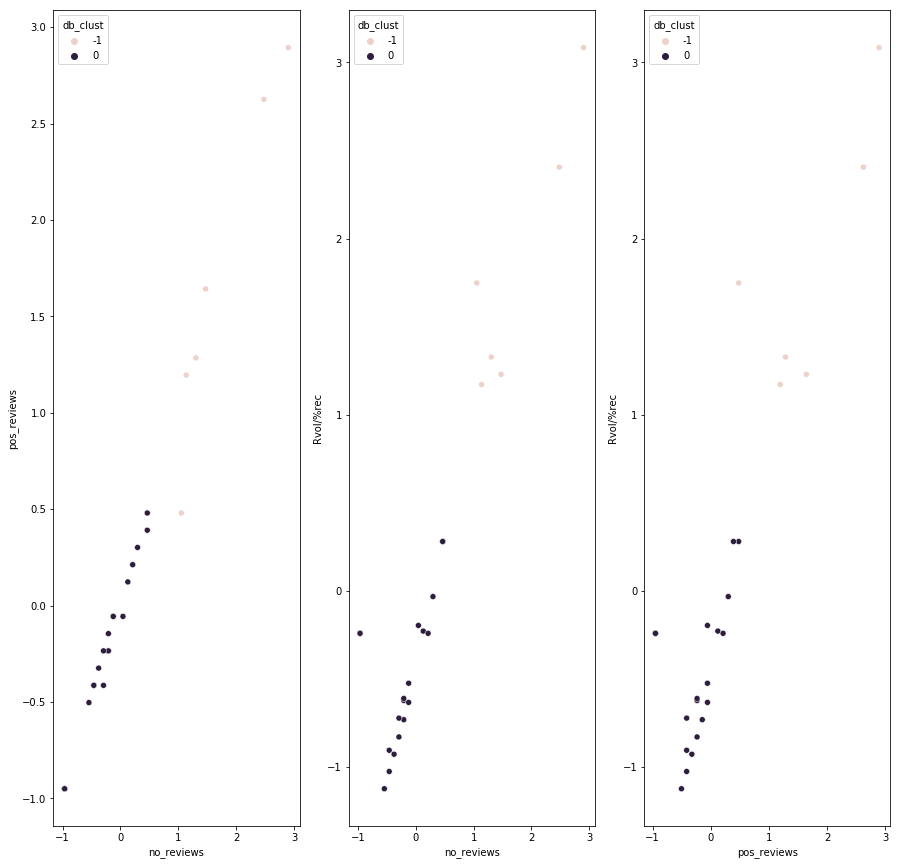

In [47]:
desktops['db_clust'] = pd.Series(db_clust, index=desktops.index)
f, axes = plt.subplots(1,3, figsize=(15,15))
sns.scatterplot(x=desktops['no_reviews'], y=desktops['pos_reviews'], hue=desktops['db_clust'],ax=axes[0])
sns.scatterplot(x=desktops['no_reviews'], y=desktops['Rvol/%rec'],hue=desktops['db_clust'], ax=axes[1])
sns.scatterplot(x=desktops['pos_reviews'], y=desktops['Rvol/%rec'],hue=desktops['db_clust'], ax=axes[2])

## tablets

In [39]:

dbscan_model = DBSCAN(eps=1.2, min_samples=(len(tablets))/5)
db_clust = dbscan_model.fit_predict(tablets[['no_reviews']])
tablets['db_clust'] = pd.Series(db_clust, index=tablets.index)
get_eval_scores(tablets['y_true'], tablets['db_clust'])

(1.0, 0.18181818181818182, 0.3076923076923077)

In [48]:
dbscan_model = DBSCAN(eps=0.95, min_samples=(len(tablets))/5)
db_clust = dbscan_model.fit_predict(tablets[['no_reviews','Rvol/%rec']])
tablets['db_clust'] = pd.Series(db_clust, index=tablets.index)
get_eval_scores(tablets['y_true'], tablets['db_clust'])

(0.6363636363636364, 0.6363636363636364, 0.6363636363636364)

In [ ]:
cluster_intelligence.cluster_report(tablets[['no_reviews','Rvol/%rec','pos_reviews']],db_clust)

In [ ]:
get_eval_scores(tablets['y_true'], tablets['db_clust'])

In [49]:
print(tablets.loc[tablets.db_clust==-1]['TOTAL_SALES'].mean())
print(tablets.loc[tablets.db_clust==-0]['TOTAL_SALES'].mean())

1.2792104284931283
-0.19275773580033434


In [ ]:
tablets['db_clust'] = pd.Series(db_clust, index=tablets.index)
f, axes = plt.subplots(1,3, figsize=(15,15))
sns.scatterplot(x=tablets['no_reviews'], y=tablets['pos_reviews'], hue=tablets['db_clust'],ax=axes[0])
sns.scatterplot(x=tablets['no_reviews'], y=tablets['Rvol/%rec'],hue=tablets['db_clust'], ax=axes[1])
sns.scatterplot(x=tablets['pos_reviews'], y=tablets['Rvol/%rec'],hue=tablets['db_clust'], ax=axes[2])